# Исследовательский анализ данных в Python и проверка гипотез.
Автор: Загиров А.А.

## Цели и задачи проекта

Провести исследовательский анализ данных экономического развития и его связи с другими показателями – сравнительное исследование стран (1960 – 2024 годы)

Разработать автоматизированный pipeline для сбора, обработки и анализа данных Всемирного банка (получение ключевых показателей через API). Визуализировать ключевые метрики и проверить гипотезу о связи экономического роста и экологического воздействия. 

Необходимо проверить гипотезу, существует ли корреляция между уровнем экономического развития страны (ВВП на душу населения) и уровнем человеческого развития, потребление ресурсов и социальный прогресс, и как эта зависимость менялась с течением времени для разных групп стран.

## Содержимое проекта

In [1]:
# Загружаем необходимые библиотеки
import requests
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import plotly.express as px

from typing import List, Optional
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select

In [2]:
!pip install psycopg2

In [3]:
!pip install plotly

In [4]:
# Параметры БД

USER = 'postgres.hvicjpgrhirgydifvbiv'
PASSWORD = 'DaF8TT+ZzR5j%p*'
HOST = 'aws-1-eu-central-1.pooler.supabase.com'
PORT = '6543'
DBNAME = 'postgres'
DATABASE_URL = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require"

In [5]:
# Создаем движок БД

engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()

In [6]:
def fetch_data_sqlalchemy(table_name, columns="*"):
    """
    Извлекает данные из указанной таблицы с использованием SQLAlchemy.

    """
    try:
        query = f"SELECT {columns} FROM {table_name}"

        result = engine.execute(query).scalars().all()  
        data = result
        print(f"Данные из таблицы '{table_name}' успешно извлечены.")
        return data

    except Exception as e:
        print(f"Ошибка при извлечении данных из таблицы '{table_name}': {e}")
        return None
    finally:
        # Закрываем сессию после выполнения запроса
        session.close()


table_name = 'test_table' 
data = fetch_data_sqlalchemy(table_name)

if data:
    print(f"Данные из таблицы '{table_name}':")
    for row in data:
        print(row)

Ошибка при извлечении данных из таблицы 'test_table': (psycopg2.OperationalError) SSL SYSCALL error: EOF detected

[SQL: select version()]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


### Получение метаданных и списка показателей используя API всемирного банка с информацией о странах

In [7]:
# Получить список стран
url = "https://api.worldbank.org/v2/country?format=json&per_page=500"  # формат JSON и количество ответов на странице

In [8]:
try:
    # Отправляем GET запрос к World Bank API
    response = requests.get(url)
    response.raise_for_status()  # Поднимает ошибку (4** или 5**) если статус некорректный

    # Парсим ответ от API в вид JSON
    data = response.json()

# Обрабатываем ошибки, если такие возникнут
except requests.exceptions.RequestException as e:
    print(f"An error occurred while fetching data: {e}")
except (IndexError, KeyError, ValueError) as e:
    print(f"An error occurred while processing the data: {e}")


In [9]:
countries = data[1]

In [10]:
# создаем датафрейм с странами
df_countries = pd.DataFrame(countries)

In [11]:
df_countries.head()

,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ABW,AW,Aruba,"{'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Lati...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'HIC', 'iso2code': 'XD', 'value': 'High...","{'id': 'LNX', 'iso2code': 'XX', 'value': 'Not ...",Oranjestad,-70.0167,12.5167
1,AFE,ZH,Africa Eastern and Southern,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
2,AFG,AF,Afghanistan,"{'id': 'MEA', 'iso2code': 'ZQ', 'value': 'Midd...","{'id': 'MNA', 'iso2code': 'XQ', 'value': 'Midd...","{'id': 'LIC', 'iso2code': 'XM', 'value': 'Low ...","{'id': 'IDX', 'iso2code': 'XI', 'value': 'IDA'}",Kabul,69.1761,34.5228
3,AFR,A9,Africa,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
4,AFW,ZI,Africa Western and Central,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,


In [12]:
# используя функцию создаем новый столбец
df_countries['region_id'] = df_countries.region.apply(lambda x: x.get('id', None))

In [13]:
for col in ['region', 'adminregion', 'incomeLevel', 'lendingType']:
    df_countries[col + '_value'] = df_countries[col].apply(lambda x: x.get('value', None))

In [14]:
df_countries = df_countries[['id', 'iso2Code', 'name', 'capitalCity', 'longitude', 'latitude',
         'region_id', 'region_value', 'adminregion_value', 'incomeLevel_value',
         'lendingType_value']]

In [15]:
old_cols = df_countries.columns.tolist()
new_cols = ['id', 'iso2_code', 'name', 'capital', 'longitude', 'latitude',
            'region_id', 'region', 'admin_region', 'income_level', 'lending_type']

change_dict = dict(zip(old_cols, new_cols))

In [16]:
# переименовываем названия столбцов
df_countries = df_countries.rename(columns=change_dict)

In [17]:
df_countries = df_countries[['id', 'iso2_code', 'name', 'region_id', 'region', 'admin_region',
         'income_level', 'capital', 'longitude', 'latitude', 'lending_type']]

In [18]:
df_countries.head()

,id,iso2_code,name,region_id,region,admin_region,income_level,capital,longitude,latitude,lending_type
0,ABW,AW,Aruba,LCN,Latin America & Caribbean,,High income,Oranjestad,-70.0167,12.5167,Not classified
1,AFE,ZH,Africa Eastern and Southern,NA,Aggregates,,Aggregates,,,,Aggregates
2,AFG,AF,Afghanistan,MEA,"Middle East, North Africa, Afghanistan & Pakistan","Middle East, North Africa, Afghanistan & Pakis...",Low income,Kabul,69.1761,34.5228,IDA
3,AFR,A9,Africa,NA,Aggregates,,Aggregates,,,,Aggregates
4,AFW,ZI,Africa Western and Central,NA,Aggregates,,Aggregates,,,,Aggregates


In [19]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            296 non-null    object
 1   iso2_code     296 non-null    object
 2   name          296 non-null    object
 3   region_id     296 non-null    object
 4   region        296 non-null    object
 5   admin_region  296 non-null    object
 6   income_level  296 non-null    object
 7   capital       296 non-null    object
 8   longitude     296 non-null    object
 9   latitude      296 non-null    object
 10  lending_type  296 non-null    object
dtypes: object(11)
memory usage: 25.6+ KB


### Получение списка показателей используя API всемирного банка

In [20]:
def download_world_bank_data() -> pd.DataFrame:
    
    '''
    Скачивает данные по выбранным индикаторам
    Returns:
        pandas.DataFrame с загруженными данными
    '''

    # созадем пустой список для хранения данных
    all_data = []
     
    url = "https://api.worldbank.org/v2/indicators?format=json"
    
    try : 
    
        response_url = requests.get(url)

    # Парсим ответ от API в вид JSON
        data_indicators = response_url.json()   
    
        print(f"Количество страниц {data_indicators[0]['pages']}")
    # добавляем обработку страниц 
        page = 1

        while page <= data_indicators[0]['pages']:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()

        # если не список, или элементов меньше 2 или нет второго элемента - прекращаем скрипт
            if not isinstance(data, list) or len(data) < 2 or not data[1]:
                break

            all_data.extend(data[1])

            page += 1
            url = f"https://api.worldbank.org/v2/indicators?format=json&page={page}"
    
    # если список с данными пустой - возвращаем пустой датафрейм
        if not all_data:
            return pd.DataFrame()

    # если данные есть - нормализуем JSON в датафрейм pandas
        df_indicators = pd.json_normalize(all_data)

    # переименовываем колонки с точками в названии
        df_indicators.columns = df_indicators.columns.str.replace('.', '_')
            
        return df_indicators
    
# Обрабатываем ошибки, если такие возникнут
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching data: {e}")
    except (IndexError, KeyError, ValueError) as e:
        print(f"An error occurred while processing the data: {e}")

In [21]:
df_indicators = download_world_bank_data()

Количество страниц 587


C:\Users\azatz\AppData\Local\Temp/ipykernel_4168/1200484195.py:47: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_indicators.columns = df_indicators.columns.str.replace('.', '_')


In [22]:
df_indicators.head()

,id,name,unit,sourceNote,sourceOrganization,topics,source_id,source_value
0,1.0.HCount.1.90usd,Poverty Headcount ($1.90 a day),,The poverty headcount index measures the propo...,LAC Equity Lab tabulations of SEDLAC (CEDLAS a...,"[{'id': '11', 'value': 'Poverty '}]",37,LAC Equity Lab
1,1.0.HCount.2.5usd,Poverty Headcount ($2.50 a day),,The poverty headcount index measures the propo...,LAC Equity Lab tabulations of SEDLAC (CEDLAS a...,"[{'id': '11', 'value': 'Poverty '}]",37,LAC Equity Lab
2,1.0.HCount.Mid10to50,Middle Class ($10-50 a day) Headcount,,The poverty headcount index measures the propo...,LAC Equity Lab tabulations of SEDLAC (CEDLAS a...,"[{'id': '11', 'value': 'Poverty '}]",37,LAC Equity Lab
3,1.0.HCount.Ofcl,Official Moderate Poverty Rate-National,,The poverty headcount index measures the propo...,LAC Equity Lab tabulations of data from Nation...,"[{'id': '11', 'value': 'Poverty '}]",37,LAC Equity Lab
4,1.0.HCount.Poor4uds,Poverty Headcount ($4 a day),,The poverty headcount index measures the propo...,LAC Equity Lab tabulations of SEDLAC (CEDLAS a...,"[{'id': '11', 'value': 'Poverty '}]",37,LAC Equity Lab


### Получение значений выбранных показателей за период 2060-2024 год

За последние десятилетия разные страны развивались по разному, поэтому решено было выбрать страны из разных регионов у которых наблюдался активный рост экономического развития (Индия, США, Индонезия, Польша, Ю.Корея, Турция). 

Для анализа выбираем показатели из различных областей.
Индикаторы: ВВП на душу населения, Общая численность населения, Доля потребления энергии из ископаемого топлива в общем потреблении энергии (%), Ожидаемая продолжительность жизни, Процент грамотного взрослого населения, Общий индекс эффективности логистики, Общий уровень безработицы, % от общей численности рабочей силы.

In [23]:
def receive_worldbank_df(indicators: List[str],
                         countries: List[str] = 'all',
                         start_year: int = 1960,
                         end_year: int = 2024,
                         language: str = 'en') -> pd.DataFrame:

    '''
    Получает данные показателей из API Всемирного банка.

    '''

    base_url = "https://api.worldbank.org/v2" # endpoint API - адрес по которому мы обращаемся за данными

    # преобразовываем страны в строку с разделителем точка с запятой (для запроса данных)
    countries_str = ';'.join(countries)

    # список для хранения данных о показателях
    all_data = []

    try:
        for indicator in indicators:
            # Формируем URL для запроса
            url = f"{base_url}/{language}/country/{countries_str}/indicator/{indicator}"
            params = {
                'format': 'json',
                'date': f"{start_year}:{end_year}",
                'per_page': 10000  # Большое значение для получения всех данных
            }
            
            print(url)

            # Выполняем запрос к API
            response = requests.get(url, params=params)
            response.raise_for_status()

            data = response.json()

            # API возвращает массив, где первый элемент - метаданные, второй - данные
            if len(data) > 1 and isinstance(data[1], list):
                for item in data[1]:
                    if item.get('value') is not None:
                        all_data.append({
                            'country': item['country']['value'],
                            'country_code': item['countryiso3code'],
                            'indicator': item['indicator']['value'],
                            'indicator_code': item['indicator']['id'],
                            'year': int(item['date']),
                            'value': item['value']
                        })

        # Создаем DataFrame
        df = pd.DataFrame(all_data)

        if df.empty:
            print("Предупреждение: Не получено данных для указанных параметров")
            return df

        return df

    # Обрабатываем возможные ошибки при работе с АПИ
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к API: {e}")
        return pd.DataFrame()
    except (KeyError, IndexError, ValueError) as e:
        print(f"Ошибка при обработке данных: {e}")
        return pd.DataFrame()


In [24]:
# Получаем данные за 2060-2024 годы
indicators = ['NY.GDP.PCAP.CD', 'SP.POP.TOTL', 'EG.USE.COMM.CL.ZS', 'SP.DYN.LE00.IN', 'SE.ADT.LITR.ZS', 'LP.LPI.OVRL.XQ', 'SL.UEM.TOTL.ZS'] 
# ВВП на душу населения, Общая численность населения, Доля потребления энергии из ископаемого топлива в общем потреблении энергии (%), 
# Ожидаемая продолжительность жизни, Процент грамотного взрослого населения, Общий индекс эффективности логистики, Общий уровень безработицы, % от общей численности рабочей силы

countries = ['IND', 'USA', 'IDN', 'POL', 'KOR', 'TUR']  # Индия, США, Индонезия, Польша, Ю.Корея, Турция
# start_year = 2010
# end_year = 2020

df = receive_worldbank_df(indicators, countries)

df.head()

https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/NY.GDP.PCAP.CD
https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/SP.POP.TOTL
https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/EG.USE.COMM.CL.ZS
https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/SP.DYN.LE00.IN
https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/SE.ADT.LITR.ZS
https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/LP.LPI.OVRL.XQ
https://api.worldbank.org/v2/en/country/IND;USA;IDN;POL;KOR;TUR/indicator/SL.UEM.TOTL.ZS


,country,country_code,indicator,indicator_code,year,value
0,Indonesia,IDN,GDP per capita (current US$),NY.GDP.PCAP.CD,2024,4925.430488
1,Indonesia,IDN,GDP per capita (current US$),NY.GDP.PCAP.CD,2023,4876.307745
2,Indonesia,IDN,GDP per capita (current US$),NY.GDP.PCAP.CD,2022,4730.834848
3,Indonesia,IDN,GDP per capita (current US$),NY.GDP.PCAP.CD,2021,4287.173140
4,Indonesia,IDN,GDP per capita (current US$),NY.GDP.PCAP.CD,2020,3853.702888


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1624 non-null   object 
 1   country_code    1624 non-null   object 
 2   indicator       1624 non-null   object 
 3   indicator_code  1624 non-null   object 
 4   year            1624 non-null   int64  
 5   value           1624 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 76.2+ KB


In [26]:
df_group_indicator= df.groupby('indicator_code').count()
df_group_indicator

,country,country_code,indicator,year,value
indicator_code,,,,,
EG.USE.COMM.CL.ZS,204,204,204,204,204
LP.LPI.OVRL.XQ,42,42,42,42,42
NY.GDP.PCAP.CD,353,353,353,353,353
SE.ADT.LITR.ZS,47,47,47,47,47
SL.UEM.TOTL.ZS,204,204,204,204,204
SP.DYN.LE00.IN,384,384,384,384,384
SP.POP.TOTL,390,390,390,390,390


In [27]:
df_group_country= df.groupby('country').count()
df_group_country

,country_code,indicator,indicator_code,year,value
country,,,,,
India,282,282,282,282,282
Indonesia,275,275,275,275,275
"Korea, Rep.",270,270,270,270,270
Poland,240,240,240,240,240
Turkiye,288,288,288,288,288
United States,269,269,269,269,269


В результате получили один датафрейм с данными по выбранным странам и индикаторам. У разных индикаторов разные значения, значит данные есть не за все года, некоторые данные только за последние несколько лет. Больше всего данных по общей численности населения - 390 записей. Для анализа будем использовать данные, значения которых больше 204. 
Если анализировать по странам, то примерно одинаковое значения показателей.

### Сохранение информацию в базу данных 

Мы получили необходимую информацию, пред началом преобразования данных необходимо сохранить исодные данные в БД.

In [28]:
os.getcwd()

'C:\\Users\\azatz'

In [29]:
conn = sqlite3.connect('data.db')  # мы создаем базу данных sqlite как файл data.db

In [30]:
df_countries.to_sql('countries', conn, if_exists='replace', index=False)  # countries название таблицы в базе данных 

In [31]:
df.to_sql('countries_indicators', conn, if_exists='replace', index=False)  # indicators название таблицы в базе данных 

### Очистка и предобработка данных 

In [32]:
# извлекаем данные из БД
df = pd.read_sql_query('select * from countries_indicators', conn)

In [33]:
# проверяем наличие пропусков
df.isna().sum()

country           0
country_code      0
indicator         0
indicator_code    0
year              0
value             0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1624 non-null   object 
 1   country_code    1624 non-null   object 
 2   indicator       1624 non-null   object 
 3   indicator_code  1624 non-null   object 
 4   year            1624 non-null   int64  
 5   value           1624 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 76.2+ KB


In [35]:
# проверяем дубликаты
df.duplicated().sum()

0


### Сравнительный анализ на карте мира.

Используя plotly.express.choropleth создали интерактивную картограмму, визуализирующую общую численность населения за выбранный период. 

In [36]:
df_map = df[df['indicator_code']=='SP.POP.TOTL']
df_map = df_map.sort_values(by='year')
# df_map

In [37]:
# визуализация количества населения по странам
fig = px.choropleth(df_map,
                    locations='country_code',  
                    color='value', 
                    hover_name='country',  
                    animation_frame='year',  
                    projection='natural earth',  
                    title='Общая численность населения',  
                    color_continuous_scale=px.colors.sequential.Plasma, 
                   )

fig.update_layout(
    geo=dict(
        showframe=False,  
        showcoastlines=False,   
    )
)

fig.show()
fig.show(renderer="browser")

### Анализ распределения.

Строим гистограммы и boxplot для ВВП на душу населения. 

In [38]:
# создаем датафрейм только с ВВП на душу населения
df_gdp=df.loc[df['indicator_code']=='NY.GDP.PCAP.CD', ['country_code', 'year', 'value']]

# df_gdp

Проверяем на выбросы, строим диаграмму размаха значений ВВП

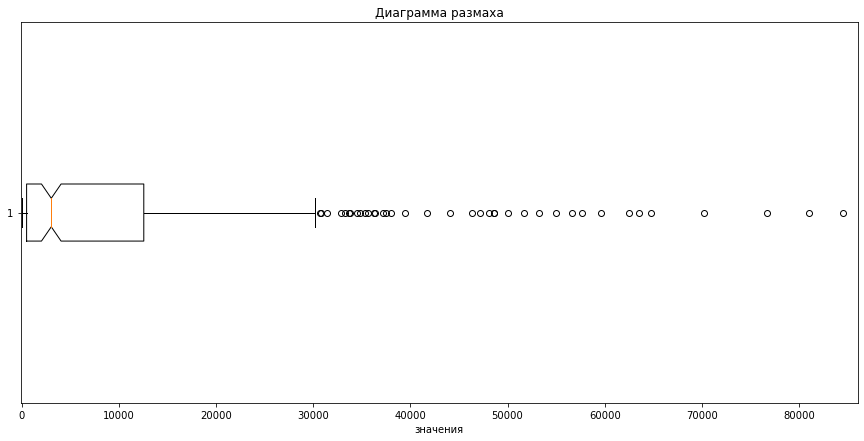

In [39]:
# Строим диаграмму размаха значений в столбце value
fig = plt.figure(figsize=(15, 7))
 
ax = fig.add_subplot(111)
plt.boxplot(df_gdp['value'], ax.set_xlim(-100, 86000),  vert=False)

# Добавляем заголовок и метки оси
plt.title('Диаграмма размаха')
plt.xlabel('значения')

# Выводим график
plt.show()

Строим линейные графики изменения ВВП за разные годы

In [40]:
# оставляем значения без выбросов
df_gdp_outlier = df_gdp[df_gdp['value'] <= df_gdp['value'].quantile(0.99)]
df_gdp_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 352
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  349 non-null    object 
 1   year          349 non-null    int64  
 2   value         349 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ KB


In [41]:
# Рассчитываем основные статистики (среднее, медиана, стандартное отклонение, минимум, максимум) для основного показателя 
df_gdp_outlier.describe()

,year,value
count,349.000000,349.000000
mean,1993.736390,9201.650530
std,18.190542,13630.677883
min,1960.000000,53.205187
25%,1978.000000,511.400884
50%,1995.000000,2999.864872
75%,2009.000000,12209.386233
max,2024.000000,64746.450678


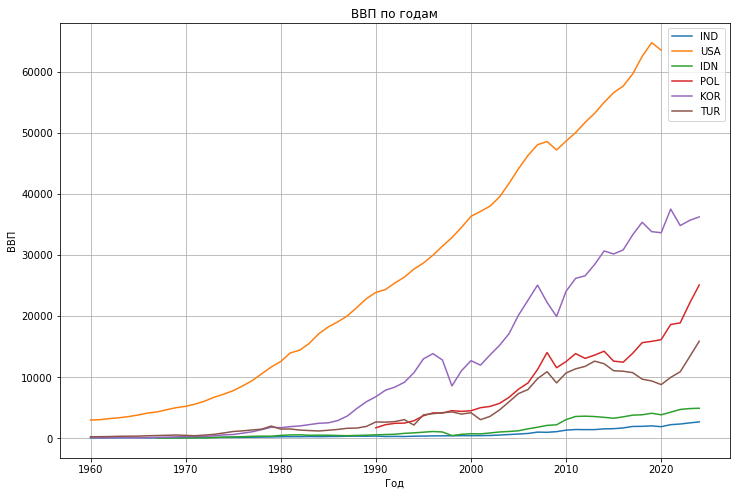

In [42]:
# Строим график ВВП на душу населения по годам
def plot_gdp_by_year(df, countries):
   

    plt.figure(figsize=(12, 8))  # Настройка размера графика

    for country in countries:
        country_data = df[df['country_code'] == country]  
        plt.plot(country_data['year'], country_data['value'], label=country)

    plt.xlabel('Год')
    plt.ylabel('ВВП')
    plt.title('ВВП по годам')
    plt.legend()  # Отображение легенды для различения стран
    plt.grid(True)  # Добавление сетки 
    plt.show()



countries_to_plot = ['IND', 'USA', 'IDN', 'POL', 'KOR', 'TUR']

# 3. Вызов функции для построения графика
plot_gdp_by_year(df_gdp_outlier, countries_to_plot)


In [43]:
# Создаем датафрейм с индикатором доля потребления энергии из ископаемого топлива 
df_co2e=df.loc[df['indicator_code']=='EG.USE.COMM.CL.ZS', ['country_code', 'year', 'value']]

In [44]:
df_co2e.describe()

,year,value
count,204.000000,204.000000
mean,2006.500000,7.790098
std,9.834843,5.415744
min,1990.000000,0.120000
25%,1998.000000,2.772500
50%,2006.500000,7.295000
75%,2015.000000,11.987500
max,2023.000000,18.620000


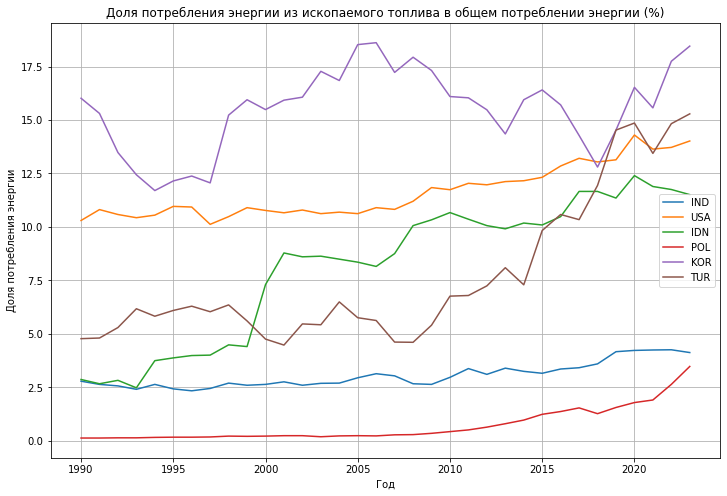

In [45]:
# Доля потребления энергии из ископаемого топлива в общем потреблении энергии (%)
def plot_co2e_by_year(df, countries):
   

    plt.figure(figsize=(12, 8))  # Настройка размера графика

    for country in countries:
        country_data = df[df['country_code'] == country]  
        plt.plot(country_data['year'], country_data['value'], label=country)

    plt.xlabel('Год')
    plt.ylabel('Доля потребления энергии')
    plt.title('Доля потребления энергии из ископаемого топлива в общем потреблении энергии (%)')
    plt.legend()  # Отображение легенды для различения стран
    plt.grid(True)  # Добавление сетки 
    plt.show()



countries_to_plot = ['IND', 'USA', 'IDN', 'POL', 'KOR', 'TUR']

# 3. Вызов функции для построения графика
plot_co2e_by_year(df_co2e, countries_to_plot)

In [46]:
df_life_exp=df.loc[df['indicator_code']=='SP.DYN.LE00.IN', ['country_code', 'year', 'value']]

df_life_exp

,country_code,year,value
947,IDN,2023,71.146000
948,IDN,2022,70.925000
949,IDN,2021,67.452000
950,IDN,2020,68.817000
951,IDN,2019,70.349000
...,...,...,...
1326,USA,1964,70.165854
1327,USA,1963,69.917073
1328,USA,1962,70.119512
1329,USA,1961,70.270732


In [47]:
df_life_exp.describe()

,year,value
count,384.000000,384.000000
mean,1991.500000,67.674267
std,18.497054,9.068161
min,1960.000000,42.762000
25%,1975.750000,62.142500
50%,1991.500000,69.892683
75%,2007.250000,74.765854
max,2023.000000,83.526829


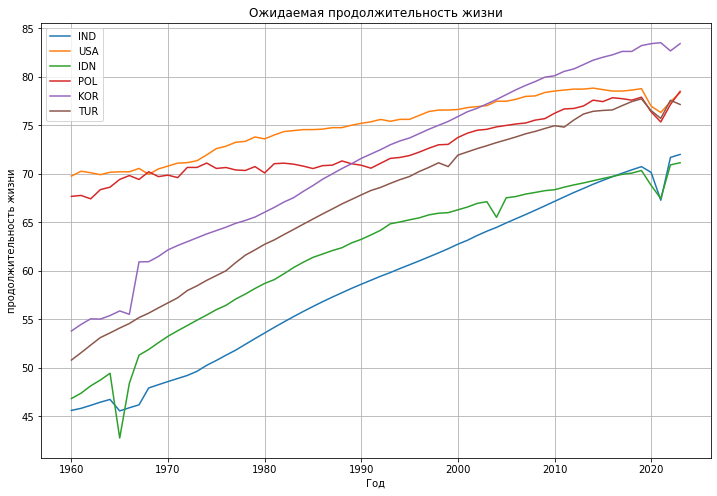

In [48]:
# Ожидаемая продолжительность жизни
def plot_life_exp_year(df, countries):
   

    plt.figure(figsize=(12, 8))  # Настройка размера графика

    for country in countries:
        country_data = df[df['country_code'] == country]  
        plt.plot(country_data['year'], country_data['value'], label=country)

    plt.xlabel('Год')
    plt.ylabel('продолжительность жизни')
    plt.title('Ожидаемая продолжительность жизни')
    plt.legend()  # Отображение легенды для различения стран
    plt.grid(True)  # Добавление сетки 
    plt.show()



countries_to_plot = ['IND', 'USA', 'IDN', 'POL', 'KOR', 'TUR']

# 3. Вызов функции для построения графика
plot_life_exp_year(df_life_exp, countries_to_plot)

Рассчитаем матрицу корреляции Пирсона между ключевыми показателями и построим графики

In [49]:
# Для каждой страны выбираем один индикатор и присоединяем к датафрейму с значениями ВВП

results = {}

for country in countries:
        df_country_gdp = df_gdp_outlier.loc[(df_gdp_outlier['country_code'] == country)] 
        df_country_gdp = df_country_gdp.rename(columns={'value': 'value_gdp'})

        df_country_part_energy = df.loc[(df['country_code'] == country) & (df['indicator_code'] == 'EG.USE.COMM.CL.ZS'), ['year', 'value']]
        df_country_part_energy = df_country_part_energy.rename(columns={'value': 'value_part_energy'})

        df_gdp_part_en = pd.merge(df_country_gdp, df_country_part_energy, on='year', how='inner')

        df_country_lein = df.loc[(df['country_code'] == country) & (df['indicator_code'] == 'SP.DYN.LE00.IN'), ['year', 'value']]
        df_country_lein = df_country_lein.rename(columns={'value': 'value_lein'})

        df_gdp_part_lein = pd.merge(df_gdp_part_en, df_country_lein, on='year', how='inner')

        df_country_jobless = df.loc[(df['country_code'] == country) & (df['indicator_code'] == 'SL.UEM.TOTL.ZS'), ['year', 'value']]
        df_country_jobless = df_country_jobless.rename(columns={'value': 'value_jobless'})

        df_converted = pd.merge(df_gdp_part_lein, df_country_jobless, on='year', how='inner')

        # Сохранение результата
        results[country] = df_converted

In [50]:
# Рассчитываем корреляцию Пирсона для создания корреляционной матрицы
for country, df_result in results.items():
        print(f'Корреляционная матрица для {country}') 
        corr_matrix = df_result[['value_gdp', 'value_part_energy', 'value_lein', 'value_jobless']].corr()  # Выбираем только нужные столбцы для корреляции
        print(corr_matrix)


Корреляционная матрица для IND
                   value_gdp  value_part_energy  value_lein  value_jobless
value_gdp           1.000000           0.927213    0.940935      -0.603016
value_part_energy   0.927213           1.000000    0.841004      -0.631476
value_lein          0.940935           0.841004    1.000000      -0.469705
value_jobless      -0.603016          -0.631476   -0.469705       1.000000
Корреляционная матрица для USA
                   value_gdp  value_part_energy  value_lein  value_jobless
value_gdp           1.000000           0.869904    0.892643      -0.013915
value_part_energy   0.869904           1.000000    0.641105       0.126832
value_lein          0.892643           0.641105    1.000000       0.082276
value_jobless      -0.013915           0.126832    0.082276       1.000000
Корреляционная матрица для IDN
                   value_gdp  value_part_energy  value_lein  value_jobless
value_gdp           1.000000           0.831973    0.890824      -0.384778
value_p

Корреляционная матрица для IND


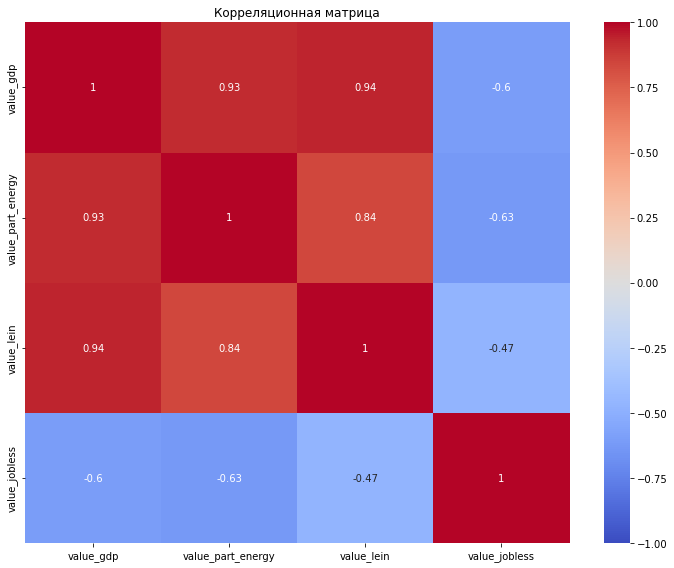

Корреляционная матрица для USA


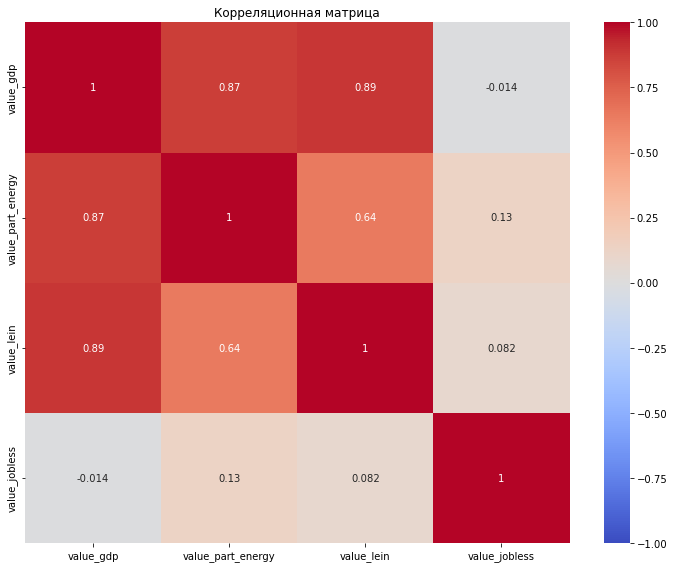

Корреляционная матрица для IDN


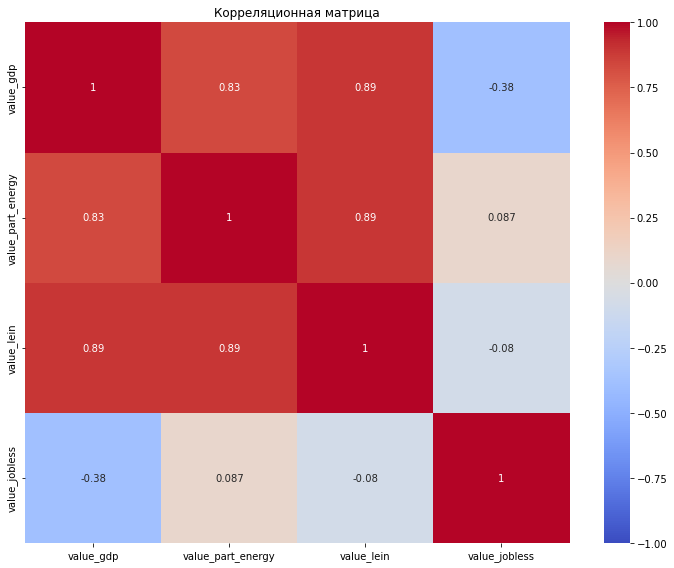

Корреляционная матрица для POL


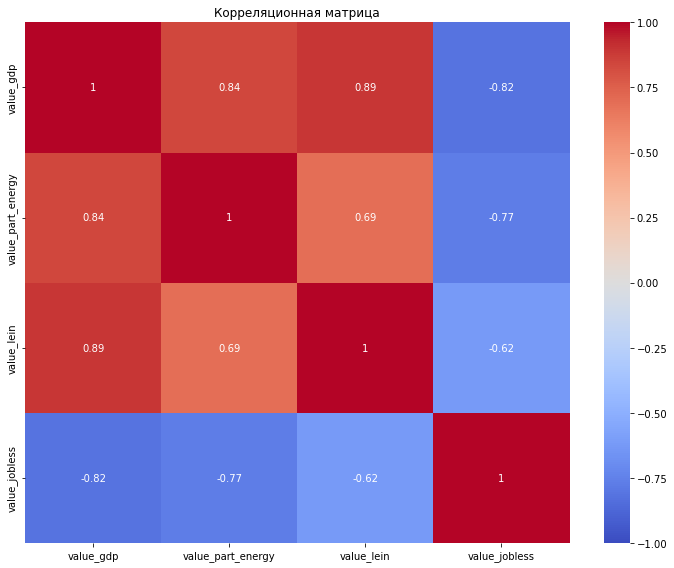

Корреляционная матрица для KOR


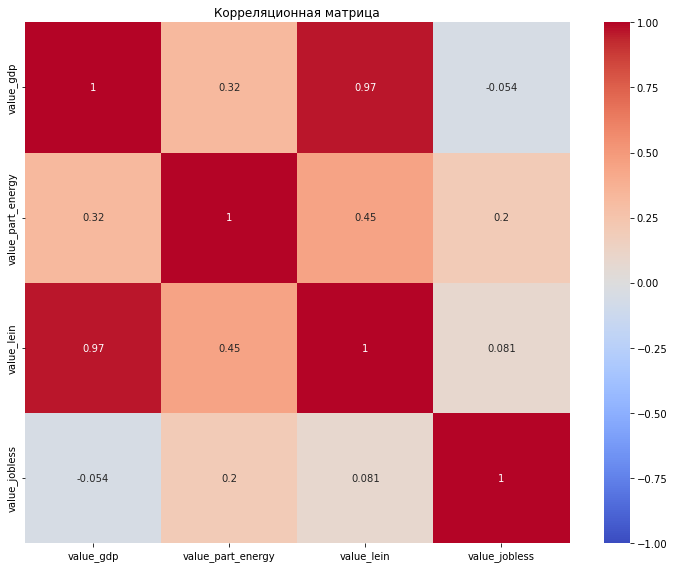

Корреляционная матрица для TUR


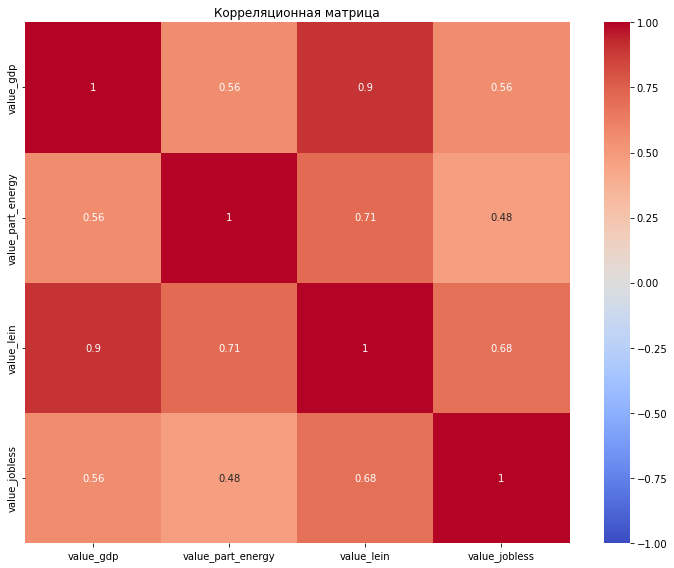

In [51]:
# Визуализация корреляционной матрицы
for country, df_result in results.items():
        print(f'Корреляционная матрица для {country}') 
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_result[['value_gdp', 'value_part_energy', 'value_lein', 'value_jobless']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)  # Используем df_new и выбираем нужные столбцы
        plt.title('Корреляционная матрица')
        plt.tight_layout()
        plt.show()

Проанализировав получившуюся матрицу, можно предположить, что ВВП на душу населения зависит от Доля потребления энергии из ископаемого топлива в общем потреблении энергии и ожидаемой продолжительности жизни. И не зависит от значения безработицы.

Построим графики рассеяния (ScatterPlots) для анализа взаимосвязей:
Ось X: ВВП на душу населения.
Ось Y: Доля потребления энергии из ископаемого топлива и Ожидаемая продолжительность жизни
Значения, которые показали наибольшую кореляцию.

In [52]:
fig = px.scatter(results.get('IND'),
                 x='value_gdp',  
                 y='value_part_energy',  
                 title="Scatter Plot")

fig.show()


In [53]:
fig = px.scatter(results.get('IND'),
                 x='value_gdp',  
                 y='value_lein',  
                 title="Scatter Plot")

fig.show()


Графики рассеяния показали линейную завмсимость. ВВП на душу населения увеличивается при увеличении доли потребления энергии    и ожидаемой продолжительности жизни в стране. 

### Вывод:


Провели исследовательский анализ данных экономического развития шести стран (ВВП на душу населения) и его связи с другими показателями: общей численности населения, доли потребления энергии из ископаемого топлива в общем потреблении энергии, ожидаемой продолжительностиь жизни, общего уровеня безработицы.

Получили значения выбранных показателей за период 2060-2024 года через API. Обработали и проанализировали данные Всемирного банка, рассчитали основные статистики.

Построили линейные графики изменения ВВП на душу населения. Используя plotly, создали интерактивную картограмму, визуализирующую общую численность населения.
Рассчитали матрицу корреляции Пирсона между ключевыми показателями и построили теловую карту взаимосвязей пеказателей.

В результате определили, что существует корреляция между уровнем экономического развития страны (ВВП на душу населения) и уровнем человеческого развития (долей потребления энергии и ожидаемой продолжительности жизни в стране) и отсутствует у общего уровеня безработицы.
